# Advantage actor-critic with GAE (A2C-GAE)

In [1]:
import numpy as np
import gym
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from IPython.display import display


In [2]:
import sys
sys.path.insert(0,'../')
from buffers.frame_buffer import FrameBuffer
from preprocessings.atari_preprocessing import AtariPreprocess
from paralleling.parallel import EnvBatch

In [3]:
def make_env():
    env = gym.make("KungFuMasterDeterministic-v0")
    env = AtariPreprocess(env,img_size=(42,42,1), crop_func=lambda x: x[60:-30, 5:, :])
    env = FrameBuffer(env, n_frames=4, dim_order='tensorflow')
    return env

env = make_env()
obs_shape = env.observation_space.shape
n_actions = env.action_space.n

print("Observation shape:", obs_shape)
print("Num actions:", n_actions)
print("Action names:", env.env.env.get_action_meanings())

Observation shape: (42, 42, 4)
Num actions: 14
Action names: ['NOOP', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'DOWNRIGHT', 'DOWNLEFT', 'RIGHTFIRE', 'LEFTFIRE', 'DOWNFIRE', 'UPRIGHTFIRE', 'UPLEFTFIRE', 'DOWNRIGHTFIRE', 'DOWNLEFTFIRE']


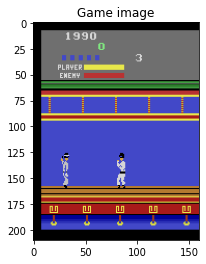

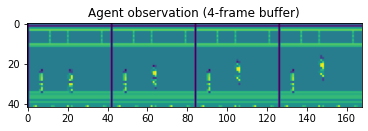

In [4]:
s = env.reset()
for _ in range(100):
    s, _, _, _ = env.step(env.action_space.sample())

plt.title('Game image')
plt.imshow(env.render('rgb_array'))
plt.show()

plt.title('Agent observation (4-frame buffer)')
plt.imshow(s.transpose([0, 2, 1]).reshape([42,-1]))
plt.show()

## Making a model

In [5]:
from tensorflow.keras.layers import Conv2D, Input, Flatten, Dense, Reshape, LSTM
from tensorflow.keras.models import Sequential, Model

In [6]:
class A2C:
    def __init__(self, name, state_shape, n_actions, 
                 gamma=0.99, alpha=0.001, beta=1, eta=1e-4, reuse=False):
        """A simple actor-critic agent"""
        self.sess = tf.InteractiveSession()
        self.gamma = gamma
        self.alpha = alpha
        self.beta = beta
        self.n_actions = n_actions
        self.eta = eta
        with tf.variable_scope(name, reuse=reuse):
            input = Input(shape=state_shape)
            body = Sequential([
            Conv2D(filters=128, kernel_size=(3,3),strides=(2,2), activation='elu'),
            Conv2D(filters=64, kernel_size=(3,3),strides=(2,2), activation='elu'),
            Conv2D(filters=32, kernel_size=(3,3),strides=(2,2), activation='elu'),
            Conv2D(filters=16, kernel_size=(3,3),strides=(2,2), activation='elu'),
            Dense(units=128,activation='elu')
            ])(input)
            logits = Dense(units=n_actions)(body)
            values = Dense(units=1)(body)
            self.model = Model(inputs=input, outputs=[logits, values])
            print(self.model.summary())
            self.state_t = tf.placeholder('float32', [None,] + list(state_shape))
            self.agent_outputs = self.symbolic_step(self.state_t)
            
        self.states_ph, self.next_states_ph, self.actions_ph, self.rewards_ph, self.is_done_ph = self.init_placeholders(state_shape)
        self.train_step, self.actor_loss, self.critic_loss, self.entropy = self.graph_flow()
        self.sess.run(tf.global_variables_initializer())

    def symbolic_step(self, state_t):
        """Takes agent's previous step and observation, returns next state and whatever it needs to learn (tf tensors)"""
        
        logits, state_values = self.model(state_t)
        state_values = tf.squeeze(state_values,axis=1)
        assert tf.is_numeric_tensor(logits) and logits.shape.ndims == 2, \
            "Please return 2D TF tensor of logits [you got %s]." % repr(logits)
        assert tf.is_numeric_tensor(state_values) and state_values.shape.ndims == 1, \
            "Please return 1D TF tensor of state values [you got %s]." % repr(state_values)
        return logits, state_values
    
    def step(self, state_t):
        """Same as symbolic step except it operates on numpy arrays"""
        return self.sess.run(self.agent_outputs, {self.state_t: state_t})
    
    def sample_actions(self, agent_outputs):
        """pick actions given numeric agent outputs (np arrays)"""
        logits, state_values = agent_outputs
        policy = np.exp(logits) / np.sum(np.exp(logits), axis=-1, keepdims=True)
        return np.array([np.random.choice(len(p), p=p) for p in policy])
    
    def init_placeholders(self,obs_shape):
        states_ph = tf.placeholder('float32', [None,] + list(obs_shape))    
        next_states_ph = tf.placeholder('float32', [None,] + list(obs_shape))
        actions_ph = tf.placeholder('int32', (None,))
        rewards_ph = tf.placeholder('float32', (None,))
        is_done_ph = tf.placeholder('float32', (None,))
        return states_ph, next_states_ph, actions_ph, rewards_ph, is_done_ph
    
    def graph_flow(self):
        logits, state_values = self.symbolic_step(self.states_ph)
        next_logits, next_state_values = self.symbolic_step(self.next_states_ph)
        next_state_values = next_state_values * (1 - self.is_done_ph)
        probs = tf.nn.softmax(logits, axis=-1)            
        logprobs = tf.nn.log_softmax(logits, axis=-1)     
        logp_actions = tf.reduce_sum(logprobs * tf.one_hot(self.actions_ph, self.n_actions), axis=-1) 
        advantage = self.rewards_ph+self.gamma*next_state_values-state_values
        assert advantage.shape.ndims == 1, "please compute advantage for each sample, vector of shape [n_envs,]"
        entropy =  - tf.reduce_sum(probs*logprobs,axis=1)
        assert entropy.shape.ndims == 1, "please compute pointwise entropy vector of shape [n_envs,] "
        self.target_state_values = self.rewards_ph+self.gamma*next_state_values
        actor_loss = -tf.reduce_mean(logp_actions * tf.stop_gradient(advantage), axis=0) - self.alpha * tf.reduce_mean(entropy, axis=0)
        critic_loss = tf.reduce_mean((state_values - tf.stop_gradient(target_state_values))**2, axis=0)
        train_step = tf.train.AdamOptimizer(self.eta).minimize(actor_loss + self.beta*critic_loss)
        return train_step, actor_loss, critic_loss, entropy
    
    def train(self,batch_states,batch_actions,batch_next_states,batch_rewards,batch_done):
         feed_dict = {
            self.states_ph: batch_states,
            self.actions_ph: batch_actions,
            self.next_states_ph: batch_next_states,
            self.rewards_ph: batch_rewards,
            self.is_done_ph: batch_done,
        }
         _, entropy, actor_loss, critic_loss = self.sess.run([self.train_step, self.entropy, self.actor_loss,self.critic_loss], feed_dict)
         return entropy, actor_loss, critic_loss

In [7]:
class GAE(A2C):
    def __init__(self, name, state_shape, n_actions, 
                 gamma=0.99, alpha=0.001, beta=1, eta=1e-4, reuse=False):
        self.gae_ph = tf.placeholder('float32', (None,))
        A2C.__init__(self, name=name, state_shape=state_shape, n_actions=n_actions, 
         gamma=0.99, alpha=0.001, beta=1, eta=1e-4, reuse=False)


    
    def graph_flow(self):
        logits, state_values = self.symbolic_step(self.states_ph)
        probs = tf.nn.softmax(logits, axis=-1)            
        logprobs = tf.nn.log_softmax(logits, axis=-1)     
        logp_actions = tf.reduce_sum(logprobs * tf.one_hot(self.actions_ph, self.n_actions), axis=-1) 
        entropy =  - tf.reduce_sum(probs*logprobs,axis=1)
        td_error = self.rewards_ph-state_values
        assert entropy.shape.ndims == 1, "please compute pointwise entropy vector of shape [n_envs,] "
        actor_loss = -tf.reduce_mean(logp_actions * self.gae_ph, axis=0) - self.alpha * tf.reduce_mean(entropy, axis=0)
        critic_loss = tf.reduce_mean((td_error)**2, axis=0)
        train_step = tf.train.AdamOptimizer(self.eta).minimize(actor_loss + self.beta*critic_loss)
        return train_step, actor_loss, critic_loss, entropy
        
    def train(self,batch_states,batch_actions,batch_cum_rewards,batch_gae):
         feed_dict = {
            self.states_ph: batch_states,
            self.actions_ph: batch_actions,
            self.rewards_ph: batch_cum_rewards,
            self.gae_ph : batch_gae
        }
         _, entropy, actor_loss, critic_loss = self.sess.run([self.train_step, self.entropy, self.actor_loss,self.critic_loss], feed_dict)
         return entropy, actor_loss, critic_loss

In [8]:
gamma = 0.99
eta = 1e-3
alpha = 0.01
beta = 1

In [9]:
a2c_gae = GAE('agent',obs_shape,n_actions, gamma=gamma, eta=eta, alpha=alpha, beta=beta)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 42, 42, 4)]  0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 128)          175856      input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 14)           1806        sequential[0][0]                 
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 1)            129         sequential[0][0]                 
Total params:

## Some testing and asserts

In [10]:
state = [env.reset()]
logits, value = a2c_gae.step(state)
print("action logits:\n", logits)
print("state values:\n", value)

action logits:
 [[-0.00392309  0.01202281 -0.0059936   0.00698002  0.00169702 -0.00516783
  -0.01544906 -0.01677123 -0.0077235  -0.00664485 -0.00885134 -0.00287528
  -0.00467027 -0.00065327]]
state values:
 [-0.00053942]


In [11]:
import scipy.signal

def cumulative_discount(rewards, coef):
    r = np.array(rewards)
    assert r.ndim >= 1
    return scipy.signal.lfilter([1], [1, float(-coef)], r[::-1], axis=0)[::-1]

In [12]:
def evaluate(agent, env, n_games=1):
    """Plays an a game from start till done, returns per-game rewards """

    game_rewards = []
    for _ in range(n_games):
        state = env.reset()

        total_reward = 0
        while True:
            if len(state.shape)<4:
                state = [state]
            action = agent.sample_actions(agent.step(state))[0]
            state, reward, done, info = env.step(action)
            total_reward += reward
            if done:
                break

        game_rewards.append(total_reward)
    return game_rewards

In [13]:
evaluate(a2c_gae,env)

[600.0]

In [14]:
def compute_gae(agent, gamma, lambda_, batch_states, batch_rewards, batch_next_states, batch_done):
    logits, state_values = agent.step(batch_states)
    _, next_state_values = agent.step(batch_next_states)
    next_state_values = next_state_values*(1-batch_done)
    td_error = batch_rewards+gamma*next_state_values - state_values
    return cumulative_discount(td_error, gamma*lambda_)

In [15]:
sys.path.insert(0,'../')
from paralleling.parallel import EnvBatch 
env_batch = EnvBatch(make_env,8)

In [16]:
def generate_trajectories(agent, env, n_steps=1000, gamma=0.99, lambda_=0.5):
    state = env.reset()
    while True:
        counter = 0 
        batch_states = []
        batch_rewards = []
        batch_actions = []
        batch_done = []
        batch_next_states = []
        done=False
        while True:                
            action = agent.sample_actions(agent.step(state))
            next_state, reward, done, _ = env.step(action)
            batch_rewards.append(reward)
            batch_actions.append(action)
            batch_states.append(state)
            batch_next_states.append(next_state)
            batch_done.append(done)
            state = next_state
            counter+=1
            if done.all() or counter>=n_steps:
                break
        batch_rewards = (np.array(batch_rewards)*0.01).T
        batch_cum_reward = np.hstack(cumulative_discount(batch_rewards,gamma))
        batch_actions = np.hstack(np.array(batch_actions).T)
        batch_states = np.vstack(np.array(batch_states).transpose(1,0,2,3,4))
        batch_next_states = np.vstack(np.array(batch_next_states).transpose(1,0,2,3,4))
        batch_rewards = np.hstack(batch_rewards)
        batch_done = np.hstack(np.array(batch_done).T)

        batch_gae = compute_gae(agent, gamma,lambda_, batch_states, batch_rewards, batch_next_states, batch_done)

        yield batch_states, batch_actions, batch_cum_reward, batch_gae, batch_done


In [17]:
# testing
next(generate_trajectories(a2c_gae, env_batch, n_steps=3))

(array([[[[0.        , 0.        , 0.        , 0.        ],
          [0.32235295, 0.        , 0.        , 0.        ],
          [0.32235295, 0.        , 0.        , 0.        ],
          ...,
          [0.32235295, 0.        , 0.        , 0.        ],
          [0.32235295, 0.        , 0.        , 0.        ],
          [0.32235295, 0.        , 0.        , 0.        ]],
 
         [[0.        , 0.        , 0.        , 0.        ],
          [0.09294118, 0.        , 0.        , 0.        ],
          [0.09294118, 0.        , 0.        , 0.        ],
          ...,
          [0.09294118, 0.        , 0.        , 0.        ],
          [0.09294118, 0.        , 0.        , 0.        ],
          [0.09294118, 0.        , 0.        , 0.        ]],
 
         [[0.        , 0.        , 0.        , 0.        ],
          [0.60313725, 0.        , 0.        , 0.        ],
          [0.60313725, 0.        , 0.        , 0.        ],
          ...,
          [0.60313725, 0.        , 0.        , 0.

## Training

In [18]:
import pandas as pd

def ewma(x, span=100):
    return pd.DataFrame({'x':np.asarray(x)}).x.ewm(span=span).mean().values



rewards_history = []
entropy_history = []
actor_history = []
critic_history = []

In [19]:
gamma = 0.99
lambda_ = 0.92
n_steps = 5

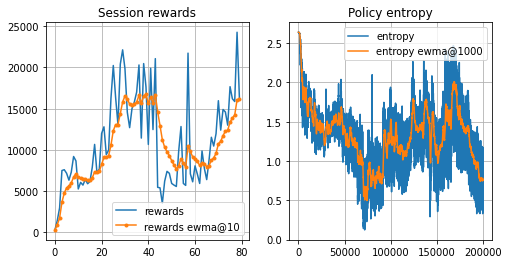

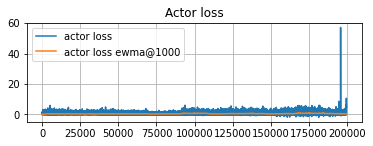

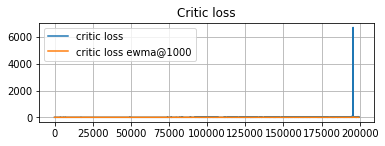

100%|██████████| 200000/200000 [3:22:09<00:00, 16.49it/s]


In [20]:
import tqdm
from IPython.display import clear_output
generator = generate_trajectories(a2c_gae,env_batch, gamma=gamma, lambda_=lambda_, n_steps=n_steps)
with tqdm.trange(len(entropy_history), 200000) as t:
    for i in t:
        batch_states, batch_actions, batch_cum_reward, batch_gae, batch_done = next(generator)
        entropy, actor_loss, critic_loss = a2c_gae.train(batch_states,batch_actions,batch_cum_reward, batch_gae)
        entropy_history.append(np.mean(entropy))
        actor_history.append(np.mean(actor_loss))
        critic_history.append(np.mean(critic_loss))

        if i % 500 == 0:
            if i % 2500 == 0:
                rewards_history.append(np.mean(evaluate(a2c_gae, env, n_games=3)))
                if rewards_history[-1] >= 5000:
                    print("Your agent has earned the yellow belt")

            clear_output(True)

            plt.figure(figsize=[8, 4])
            plt.subplot(1, 2, 1)
            plt.plot(rewards_history, label='rewards')
            plt.plot(ewma(np.array(rewards_history), span=10), marker='.', label='rewards ewma@10')
            plt.title("Session rewards")
            plt.grid()
            plt.legend()

            plt.subplot(1, 2, 2)
            plt.plot(entropy_history, label='entropy')
            plt.plot(ewma(np.array(entropy_history), span=1000), label='entropy ewma@1000')
            plt.title("Policy entropy")
            plt.grid()
            plt.legend()
            plt.show()
            
            plt.subplot(2, 1, 1)
            plt.plot(actor_history, label='actor loss')
            plt.plot(ewma(np.array(actor_history), span=1000), label='actor loss ewma@1000')
            plt.title("Actor loss")
            plt.grid()
            plt.legend()
            plt.show()
            
            plt.subplot(2, 1, 2)
            plt.plot(critic_history, label='critic loss')
            plt.plot(ewma(np.array(critic_history), span=1000), label='critic loss ewma@1000')
            plt.title("Critic loss")
            plt.grid()
            plt.legend()
            plt.show()
            
            
            

## Visualization

In [21]:
def show_state(env, step=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("Step: %d %s" % (step, info))
    plt.axis('off')

    clear_output(wait=True)
    display(plt.gcf())

Sum of rewards : 15800.0


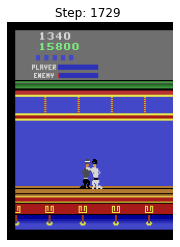

In [23]:
env = make_env()
steps = 10000
s = env.reset()
rewards = 0
last_info = None
for t in range(steps):
    show_state(env,t)
    env.render()
    a = a2c_gae.sample_actions(a2c_gae.step([s]))[0]
    next_s, r, done, info = env.step(a)
    rewards+=r
    s = next_s
    if done:
        print("Episode finished after {} timesteps".format(t+1))
        break
env.close()
clear_output(wait=True)
print("Sum of rewards : {}".format(rewards))